In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Nohai , Claudiu-Teodor (1038442)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I started with the models we discussed in the labs, and adapted values to get the required aqquracy. The balance was to add enough layers and nodes for the graph to not converge too quick and be able to "observe" all information, while not exceding an upper threshhold where the model starts overfitting. The graph seems to continue learning at high numbers of epoch.  (length: 369)



Max val score: 68.21%


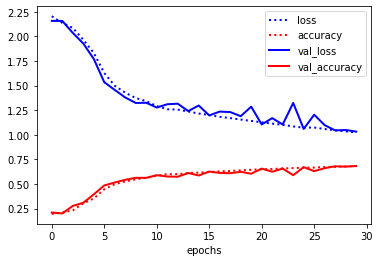

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_2 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2432      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 981,137
Trainable params: 981,137
Non-trainable params: 0
__________________________________________________

def build_model_1_1():
  model = models.Sequential()
  model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
  model.add(layers.Dense(300, activation='sigmoid'))
  model.add(layers.Dense(150, activation='sigmoid'))
  model.add(layers.Dense(75, activation='sigmoid'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model



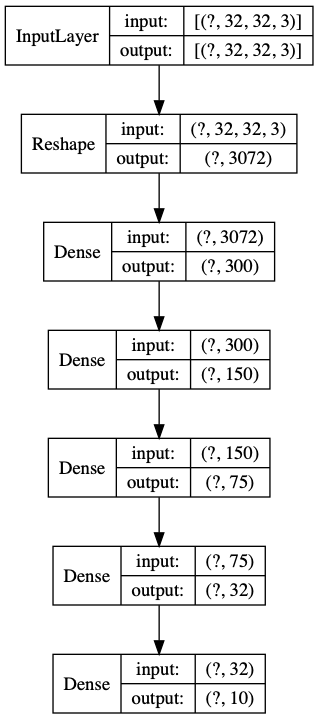

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

The first observation is that the model tends to train faster. I have also touched the values inside the model, by increasing the learning rate through the batch_size, and lowering the number of nodes to accomodate for the faster learning. The speed is most likely due to the compression of information (or abstraction), by losing the colour information, as we are more interested in the shape.  (length: 396)



Max val score: 81.37%


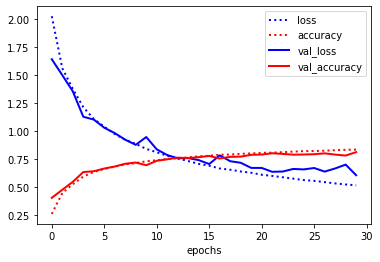

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               307500    
_________________________________________________________________
dense_6 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_7 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2432      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 366,737
Trainable params: 366,737
Non-trainable params: 0
________________________________________________

def build_model_1_2():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.Dense(300, activation='sigmoid'))
  model.add(layers.Dense(150, activation='sigmoid'))
  model.add(layers.Dense(75, activation='sigmoid'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

The model performs slightly better with batch normalisation and a very slight regularizer previous to the deciding layer. THe regularizer seems to solve a problem encountered at very high epoch numbers, as the model tends to go towards an overfit. The batch normalization will generalize the data, makeing it easier to clasify for the following layers.  (length: 354)



Max val score: 84.20%


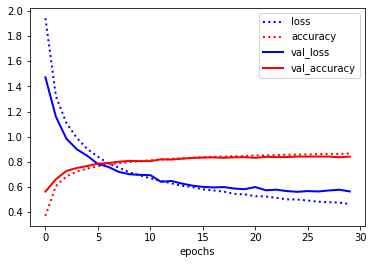

def build_model_1_3():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(200, activation='sigmoid')) #kernel_regularizer=regularizers.l1(0.01)))
  model.add(layers.Dense(120, activation='sigmoid'))
  model.add(layers.Dense(75, activation='sigmoid'))
  model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
  #model.add(layers.BatchNormalization())
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model;



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I have used the same strategy hinted in the labs, where we create pairs of conv2D layers and maxPooling2D to focus our layers on certain parts of the image. In this case, i have 3 such pairs, with quite a high nodecount starting conv2D layer, and then halving the resolution with a maxPool. The following layers have increased number of filters, to account for the maxPool resolution change. Data is normalised between each layer to squeze some extra accuracy at the end. The model keeps learning even after 30 epochs, but slighly  (length: 532)



Max val score: 94.06%


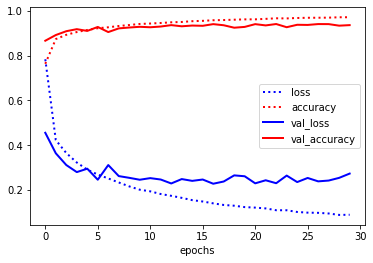

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 6, 6, 128)         512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)       

def build_model_2_1():
  model = models.Sequential()
  #model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  #model.add(layers.Conv2D(64, (3, 3), input_shape=(32,32,1), activation="relu"))
  model.add(layers.Conv2D(64, (3, 3), input_shape=(32,32,1), activation="relu"))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())
  #model.add(layers.Conv2D(128, (3, 3), input_shape=(32,32,1), activation="relu"))
  model.add(layers.Conv2D(128, (3, 3), input_shape=(32,32,1), activation="relu"))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())
  #model.add(layers.Conv2D(256, (3, 3), input_shape=(32,32,1), activation="relu"))
  #model.add(layers.Conv2D(256, (3, 3), input_shape=(32,32,1), activation="relu"))
  model.add(layers.Conv2D(256, (3, 3), input_shape=(32,32,1), activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='

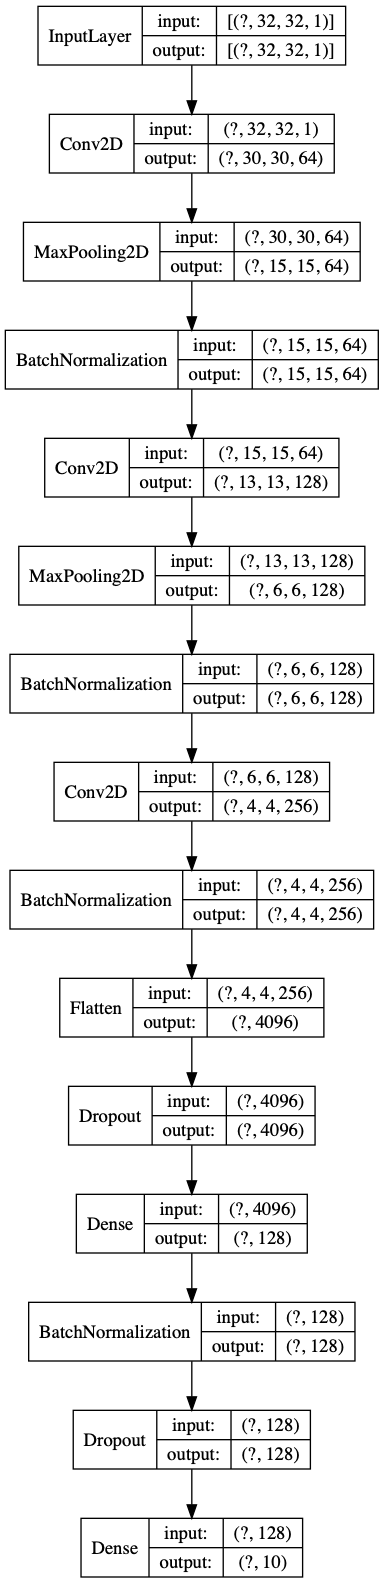

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

For the rotation range, 15 degrees seems to give the best results, and doesn't risk turning digits like 6 in 9. The shift has been slightly adjusted to account for numbers that are slihtly out-centered but to avoid cropped numbers. The flips are off to avoid turning 6 to 9. The model converges, but seems that the settings themselves might have negative impact on the training, for short runs.  (length: 396)



Max val score: 88.98%


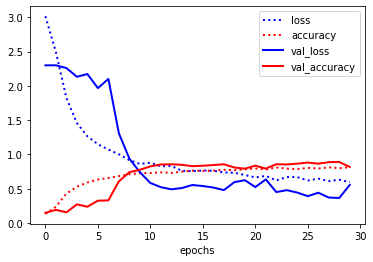


imgAug = ImageDataGenerator(
      rotation_range = 15,     
      width_shift_range = 0.1, 
      height_shift_range = 0.1,
      #shear_range = 0.2,       
      horizontal_flip = False,  # No need for flips as it changes meaning (6 to 9)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

It seems like classes that lack features or have other more detailed nubmers next to them (weak numbers being 1, or 7, and usually errors pop up when coupled with numbers such as 2, 3, 5, or 6) By analysing number 2, I have identified that one of the major problems is blurryness. Some handwritings will have 2 with an extra squigly line atat the base of the number, which seems to fool the model into thinking it is 3. The problem with 2 numbers appears here as well, where due to the tilt and angle of the image, 2 appears like 1 or is overshadowed by other numbers. The model doesn't seem to be able to pick between multiple numbers (and it shouldn't?!)  (length: 658)

Test score: 0.82%


Actual class 2


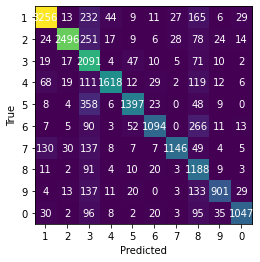

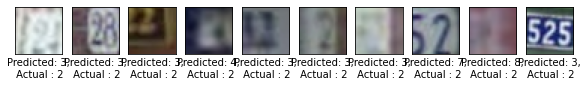

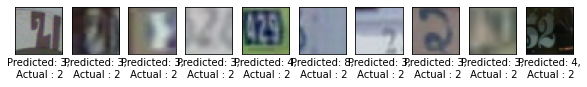

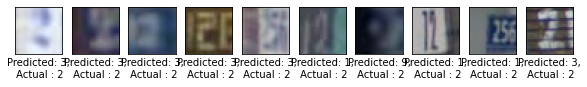

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

Your answer  (length: 13)



#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

def plot_3_3():
  pass



#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

The accuracy rises when the last convloutional layers are unfrozen, and it makes sense since this allows the model to classify the data comming from the upper layers, since the givem model base is a general image classifier, not especially made for digits. The layers thus allow it to specialise on the task.  (length: 310)



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
Total params: 14,781,642
Trainable params: 7,146,378
Non-trainable params: 7,635,264
_________________________________________________________________
Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?
Model not found
def build_model_4_1():

  baseModel = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

  lastLayers =

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

Your answer  (length: 13)

None
def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  pass

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.
  """
  pass



In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 30.29 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
